In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
data = data.dropna(subset=["Class"])
X = data.drop("Class", axis=1)
y = data["Class"]

In [4]:
X = X.fillna(0)

In [5]:
scaler = StandardScaler()
X[["Amount", "Time"]] = scaler.fit_transform(X[["Amount", "Time"]])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",  # penalize fraud misclassification
    random_state=42
)
rf.fit(X_train_res, y_train_res)

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("\n=== RandomForest Results ===")
print(classification_report(y_test, rf_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))



=== RandomForest Results ===
              precision    recall  f1-score   support

         0.0     0.9998    0.9995    0.9997      4359
         1.0     0.8889    0.9412    0.9143        17

    accuracy                         0.9993      4376
   macro avg     0.9443    0.9704    0.9570      4376
weighted avg     0.9993    0.9993    0.9993      4376

ROC-AUC: 0.9999055368878453


In [10]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # imbalance ratio
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n=== XGBoost Results ===")
print(classification_report(y_test, xgb_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:29:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Results ===
              precision    recall  f1-score   support

         0.0     0.9998    0.9993    0.9995      4359
         1.0     0.8421    0.9412    0.8889        17

    accuracy                         0.9991      4376
   macro avg     0.9209    0.9702    0.9442      4376
weighted avg     0.9992    0.9991    0.9991      4376

ROC-AUC: 0.9999325263484609


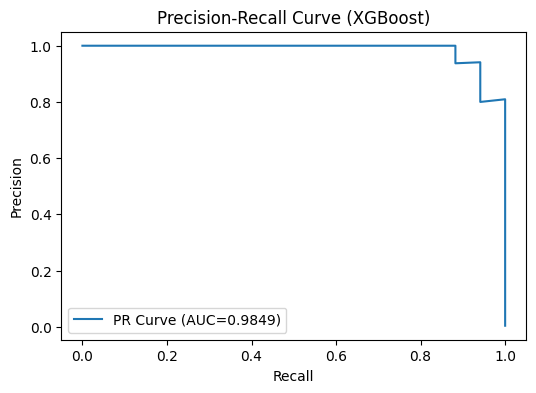

In [11]:
precisions, recalls, thresholds = precision_recall_curve(y_test, xgb_proba)
pr_auc = auc(recalls, precisions)

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR Curve (AUC={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.legend()
plt.show()


In [12]:
desired_recall = 0.95
idx = np.argmax(recalls >= desired_recall)
best_threshold = thresholds[idx] if idx < len(thresholds) else 0.5
print(f"\nBest threshold for Recall >= {desired_recall}: {best_threshold:.3f}")



Best threshold for Recall >= 0.95: 0.000


In [13]:
xgb_adjusted_pred = (xgb_proba >= best_threshold).astype(int)
print("\n=== XGBoost (Adjusted Threshold) ===")
print(classification_report(y_test, xgb_adjusted_pred, digits=4))


=== XGBoost (Adjusted Threshold) ===
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      4359
         1.0     0.0039    1.0000    0.0077        17

    accuracy                         0.0039      4376
   macro avg     0.0019    0.5000    0.0039      4376
weighted avg     0.0000    0.0039    0.0000      4376



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from sklearn.metrics import f1_score

best_f1, best_thresh = 0, 0
for t in thresholds:
    preds = (xgb_proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"Best threshold (by F1): {best_thresh:.4f}, F1: {best_f1:.4f}")


Best threshold (by F1): 0.7464, F1: 0.9412


In [15]:
from sklearn.metrics import classification_report

xgb_adjusted_pred = (xgb_proba >= 0.7464).astype(int)
print(classification_report(y_test, xgb_adjusted_pred, digits=4))


              precision    recall  f1-score   support

         0.0     0.9998    0.9998    0.9998      4359
         1.0     0.9412    0.9412    0.9412        17

    accuracy                         0.9995      4376
   macro avg     0.9705    0.9705    0.9705      4376
weighted avg     0.9995    0.9995    0.9995      4376



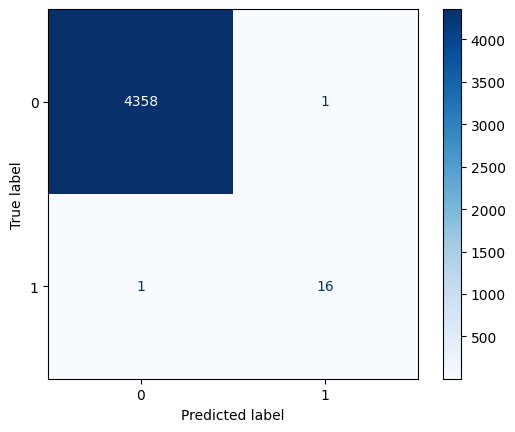

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, xgb_adjusted_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()


In [17]:
import joblib
joblib.dump((xgb_model, 0.7464), "fraud_model.pkl")


['fraud_model.pkl']